<a href="https://colab.research.google.com/github/ducviet00/MNIST-Handwritten-Digit-Recognition-from-scratch/blob/master/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, ZeroPadding2D
from keras.layers import AveragePooling2D, Input, Flatten, MaxPooling2D, Add
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
from keras.utils import np_utils
import numpy as np
import os

Using TensorFlow backend.


In [ ]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 40:
        lr *= 0.5e-3
    elif epoch > 30:
        lr *= 1e-3
    elif epoch > 20:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [ ]:
def resnet_block(X, f, filters, s = 1, conv_block = False):

    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    X = Conv2D(F1, (1, 1), strides = (s,s), padding = 'valid', kernel_initializer = 'he_normal', kernel_regularizer=l2(1e-4))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', kernel_initializer = 'he_normal', kernel_regularizer=l2(1e-4))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    X = Conv2D(F3, (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = 'he_normal', kernel_regularizer=l2(1e-4))(X)
    X = BatchNormalization(axis = 3)(X)

    if conv_block:
        X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding = 'valid', kernel_initializer = 'he_normal', kernel_regularizer=l2(1e-4))(X_shortcut)
        X_shortcut = BatchNormalization(axis = 3)(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def resnet_v2(input_shape, num_classes=10):
    """
    ResNet Version 2 Model builder - ResNet50

    """
    X_input = Input(input_shape)

    #X = ZeroPadding2D((3,3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (3,3), strides = (1,1), padding='same', kernel_initializer = 'he_normal', kernel_regularizer=l2(1e-4))(X_input)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2), strides=(2,2))(X)

    # Stage 2
    X = resnet_block(X, f=3, filters=[64,64,128], s=1, conv_block=True)
    X = resnet_block(X, f=3, filters=[64,64,128], s=1, conv_block=False)
    X = resnet_block(X, f=3, filters=[64,64,128], s=1, conv_block=False)

    # Stage 3
    X = resnet_block(X, f=3, filters=[128,128,256], s=2, conv_block=True)
    for i in range(3):
        X = resnet_block(X, f=3, filters=[128,128,256])

      
    # Stage 4
    X = resnet_block(X, f=3, filters=[256,256,512], s=2, conv_block=True) 
    for i in range(5):
        X = resnet_block(X, f=3, filters=[256,256,512])

    
    # Stage 5
    X = resnet_block(X, f=3, filters=[512,512,1024], s=2, conv_block=True)
    for i in range(2):
        X = resnet_block(X, f=3, filters=[512,512,1024])
    
    
    X = AveragePooling2D(pool_size=2)(X)

    Y = Flatten()(X) 
    Y = Dense(num_classes, activation='softmax', kernel_initializer = 'he_normal')(Y)

    model = Model(inputs = X_input, outputs = Y, name='ResNet50')
    return model


In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_val, y_val = X_train[int(0.85*len(X_train)):,:], y_train[int(0.85*len(X_train)):]
X_train, y_train = X_train[:int(0.85*len(X_train)),:], y_train[:int(0.85*len(y_train))]
print(X_train.shape)

print(X_val.shape)

shape = X_train[0].shape
shapeX_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_val = X_val.reshape(X_val.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)

X_train = X_train/255.
X_test = X_test/255.
X_val = X_val/255.
print(X_train.shape)

# 4. One hot encoding label (Y)
Y_train = np_utils.to_categorical(y_train, 10)
Y_val = np_utils.to_categorical(y_val, 10)
Y_test = np_utils.to_categorical(y_test, 10)
print('Dữ liệu y ban đầu ', y_train[0])
print('Dữ liệu y sau one-hot encoding ',Y_train[0])

(42500, 32, 32, 3)
(7500, 32, 32, 3)
(42500, 32, 32, 3)
Dữ liệu y ban đầu  [6]
Dữ liệu y sau one-hot encoding  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [ ]:
# Input image dimensions.
input_shape = X_train[0].shape

# number of classes
classes = Y_train.shape[1]

In [ ]:
model = resnet_v2(input_shape=input_shape, num_classes=classes)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy']) 


Learning rate:  0.001


In [ ]:
lr_scheduler = LearningRateScheduler(lr_schedule)

callbacks = [lr_scheduler]

In [ ]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_121 (Conv2D)             (None, 32, 32, 64)   1792        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_121 (BatchN (None, 32, 32, 64)   256         conv2d_121[0][0]                 
__________________________________________________________________________________________________
activation_112 (Activation)     (None, 32, 32, 64)   0           batch_normalization_121[0][0]    
___________________________________________________________________________________________

In [ ]:
H = model.fit(X_train, Y_train, validation_data=(X_val, Y_val),
              batch_size=128, epochs=25, verbose=1, callbacks=callbacks)

Train on 42500 samples, validate on 7500 samples
Epoch 1/25
Learning rate:  0.001
42500/42500 [==============================] - 77s 2ms/step - loss: 5.0047 - accuracy: 0.3969 - val_loss: 5.3340 - val_accuracy: 0.3149
Epoch 2/25
Learning rate:  0.001
42500/42500 [==============================] - 61s 1ms/step - loss: 4.0544 - accuracy: 0.5557 - val_loss: 4.3857 - val_accuracy: 0.4252
Epoch 3/25
Learning rate:  0.001
42500/42500 [==============================] - 61s 1ms/step - loss: 3.3420 - accuracy: 0.6306 - val_loss: 3.3301 - val_accuracy: 0.5759
Epoch 4/25
Learning rate:  0.001
42500/42500 [==============================] - 61s 1ms/step - loss: 2.7790 - accuracy: 0.6889 - val_loss: 2.9678 - val_accuracy: 0.5831
Epoch 5/25
Learning rate:  0.001
42500/42500 [==============================] - 61s 1ms/step - loss: 2.4066 - accuracy: 0.7192 - val_loss: 3.0027 - val_accuracy: 0.5148
Epoch 6/25
Learning rate:  0.001
42500/42500 [==============================] - 61s 1ms/step - loss: 2.031

In [ ]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

10000/10000 [==============================] - 7s 663us/step
Loss = 2.3142249071121217
Test Accuracy = 0.765500009059906


In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15.0, 10.0)
def plot_history(H):
    fig, ax = plt.subplots(1,2)
    ax[0].set_title('Loss')
    ax[0].plot(H.history['loss'], c='blue', label='loss')
    ax[0].plot(H.history['val_loss'], c='green', label='val_loss', linestyle='--')

    ax[1].set_title('accuracy')
    ax[1].plot(H.history['accuracy'], c='blue', label='accuracy')
    ax[1].plot(H.history['val_accuracy'], c='green', label='val_accuracy', linestyle='--')

    fig.legend('best')
    fig.show()

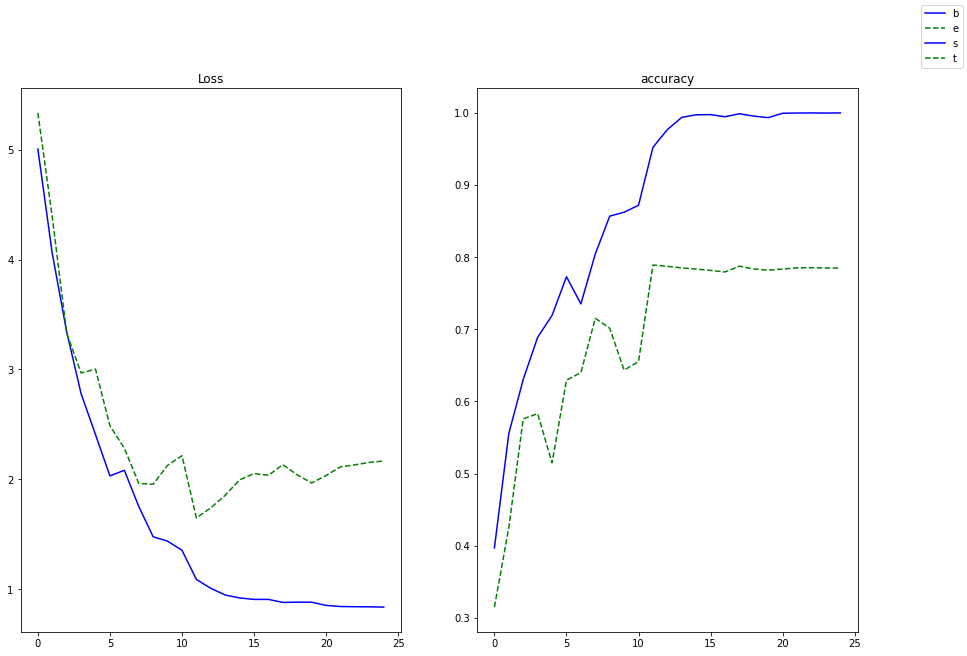

In [ ]:
plot_history(H)